In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import lsst.sims.photUtils as pt
import lsst.syseng.throughputs as st

Read in the hardware throughput components, including the filters. I'm using the syseng_throughputs source here, although the 'throughputs' repo would work too, but this does add access to ITL and E2V throughput curves (design versions). https://github.com/lsst-pst/syseng_throughputs

In [3]:
defaultDirs = st.setDefaultDirs()
e2vdir = os.path.join(os.path.split(defaultDirs['detector'])[0], 'e2v')
itldir = os.path.join(os.path.split(defaultDirs['detector'])[0], 'itl')

components_list = list(defaultDirs.keys())
addLosses = True

filter_list = ['u', 'g', 'r', 'i', 'z', 'y']

components = {}
detectors = {}
filters = {}
detectors['detector'] = st.buildDetector(defaultDirs['detector'], addLosses)
detectors['e2v'] = st.buildVendorDetector(e2vdir, addLosses)
detectors['itl'] = st.buildVendorDetector(itldir, addLosses)
components['lens1'] = st.buildLens(defaultDirs['lens1'], addLosses)
components['lens2'] = st.buildLens(defaultDirs['lens2'], addLosses)
components['lens3'] = st.buildLens(defaultDirs['lens3'], addLosses)
filters['filters'] = st.buildFilters(defaultDirs['filters'], addLosses)
components['mirror1'] = st.buildMirror(defaultDirs['mirror1'], addLosses)
components['mirror2'] = st.buildMirror(defaultDirs['mirror2'], addLosses)
components['mirror3'] = st.buildMirror(defaultDirs['mirror3'], addLosses)

Text(0.5, 1.0, 'Filter Throughput')

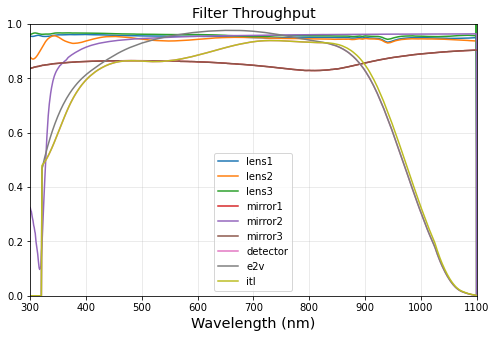

In [4]:
# Plot all of the hardware components except the filters.
plt.figure(figsize=(8, 5))
for k in components:
    plt.plot(components[k].wavelen, components[k].sb, label=k)
for d in detectors:
    plt.plot(detectors[d].wavelen, detectors[d].sb, label=d)
plt.grid(True, alpha=0.3)
plt.xlim(300, 1100)
plt.ylim(0, 1)
plt.legend()
plt.xlabel('Wavelength (nm)', fontsize='x-large')
plt.title('Filter Throughput', fontsize='x-large')

0.0 0.0


Text(0.5, 1.0, 'Component Throughput')

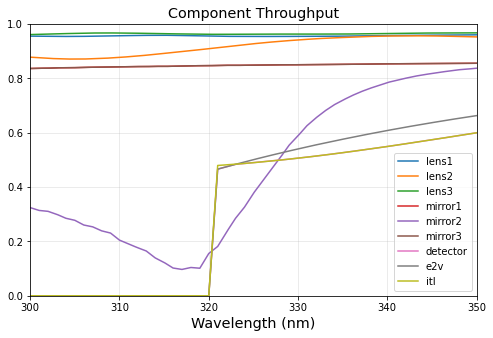

In [5]:
# Plot all of the hardware components except the filters - zoomed in to check the 300-350nm range.
# Note that the detectors (both E2V and ITL) have no sensitivity from 300-320nm. 
plt.figure(figsize=(8, 5))
for k in components:
    plt.plot(components[k].wavelen, components[k].sb, label=k)
for d in detectors:
    plt.plot(detectors[d].wavelen, detectors[d].sb, label=d)
plt.grid(True, alpha=0.3)
plt.xlim(300, 350)
plt.ylim(0, 1)
plt.legend()
match = np.where(detectors['detector'].wavelen < 320)
print(detectors['itl'].sb[match].max(), detectors['e2v'].sb[match].max())
plt.xlabel('Wavelength (nm)', fontsize='x-large')
plt.title('Component Throughput', fontsize='x-large')

u 0.90
g 0.93
r 0.94
i 0.93
z 0.93
y 0.94


Text(0.5, 1.0, 'Filter Throughput')

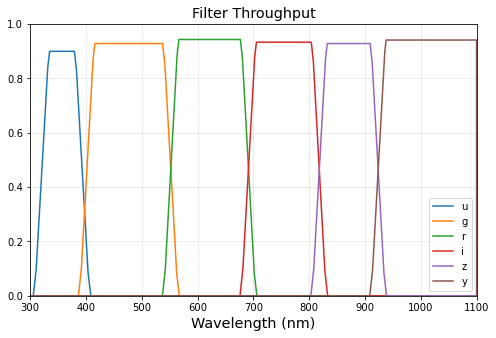

In [6]:
# Plot the standard filter throughputs. Peaks are close to, but not equal to, 1.
plt.figure(figsize=(8, 5))
peaks = {}
for f in filter_list:
    plt.plot(filters['filters'][f].wavelen, filters['filters'][f].sb, label=f)
    peaks[f] = filters['filters'][f].sb.max()
    print(f'{f} {peaks[f]:.2f}')
plt.grid(True, alpha=0.3)
plt.xlim(300, 1100)
plt.ylim(0, 1)
plt.legend()
plt.xlabel('Wavelength (nm)', fontsize='x-large')
plt.title('Filter Throughput', fontsize='x-large')

Now make leaky versions of the filters too. Top-hat from 300-350nm, with peak 0.001 * max (optionally, peak = 0.001).

In [7]:
boxfilter = np.zeros(len(filters['filters']['u'].wavelen), float)
match = np.where(filters['filters']['u'].wavelen <= 350)
boxfilter[match] = 0.001 

filters['leakyfilters'] = {}
# u is not leaky
filters['leakyfilters']['u'] = pt.Bandpass(wavelen=filters['filters']['u'].wavelen,
                                           sb=filters['filters']['u'].sb)
# grizy are leaky
for f in ['g', 'r', 'i', 'z', 'y']:
    sb = filters['filters'][f].sb + boxfilter * peaks[f]
    filters['leakyfilters'][f] = pt.Bandpass(wavelen=filters['filters'][f].wavelen, sb=sb)

Text(0.5, 1.0, 'Filter Throughput')

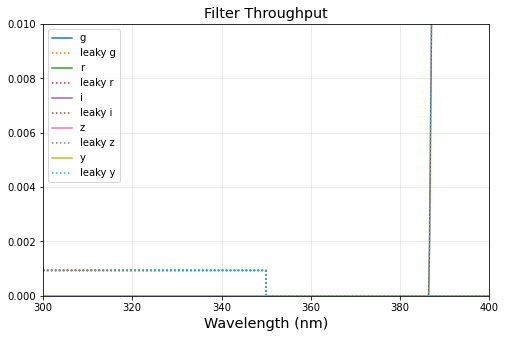

In [8]:
# Plot the standard and leaky filter throughputs in the leaky wavelength range.
plt.figure(figsize=(8, 5))
peaks = {}
for f in ['g', 'r', 'i', 'z', 'y']:
    plt.plot(filters['filters'][f].wavelen, filters['filters'][f].sb, label=f)
    plt.plot(filters['leakyfilters'][f].wavelen, filters['leakyfilters'][f].sb, 
             linestyle=':', label=f'leaky {f}')
plt.grid(True, alpha=0.3)
plt.xlim(300, 400)
plt.ylim(0, 0.01)
plt.legend()
plt.xlabel('Wavelength (nm)', fontsize='x-large')
plt.title('Filter Throughput', fontsize='x-large')

Read in atmospheres at a range of airmasses, with standard atmosphere. These are from the throughputs repo, using a standard MODTRAN atmosphere. In the repo, there are versions with and without added aerosols (the aerosols are added in the same way as they were to the 'site' atmospheres in the syseng_throughputs repo). We'll use the ones with added aerosols. https://github.com/lsst/throughputs

In [9]:
atmodir = os.path.join(os.getenv('THROUGHPUTS_DIR'), 'atmos')
atmospheres = {}

files = glob.glob(atmodir + '/atmos*[0-9]_aerosol.dat')
for f in files:
    airmass = float(os.path.split(f)[1].split('_')[1])/10
    atmospheres[airmass] = pt.Bandpass()
    atmospheres[airmass].readThroughput(f)
    
airmasses = np.sort(list(atmospheres.keys()))

Text(0.5, 1.0, 'Atmospheres')

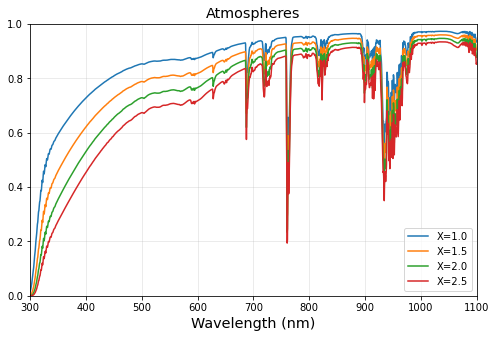

In [10]:
plt.figure(figsize=(8,5))
for x in [1.0, 1.5, 2.0, 2.5]:
    plt.plot(atmospheres[x].wavelen, atmospheres[x].sb, label=f'X={x}')
plt.grid(True, alpha=0.3)
plt.xlim(300, 1100)
plt.ylim(0, 1)
plt.legend()
plt.xlabel('Wavelength (nm)', fontsize='x-large')
plt.title('Atmospheres', fontsize='x-large')

So now let's build combined "total" throughputs (atmosphere + hardware) for each atmosphere and each version of the detector. 

(and use 'insider knowledge' that the throughputs from most of the components will already be gridded onto the same wavelength range, although the atmospheres may not be)

In [11]:
total = {}

tmpBandpass = pt.Bandpass()
for d in detectors:
    total[d] = {}
    for fi in ['filters', 'leakyfilters']:
        total[d][fi] = {}
        # Multiply hardware (except for filters) together
        wavelen = detectors[d].wavelen
        sb = np.copy(detectors[d].sb)
        for k in components:
            sb *= components[k].sb
        for f in filter_list:
            # Multiply in filters
            total[d][fi][f] = {}
            tmpBandpass.setBandpass(wavelen=wavelen, sb=sb*filters[fi][f].sb)
            for x in airmasses:
                # Now add atmosphere
                wavelen_x, sb_x = tmpBandpass.multiplyThroughputs(atmospheres[x].wavelen, atmospheres[x].sb)
                total[d][fi][f][x] = st.Bandpass()
                total[d][fi][f][x].setBandpass(wavelen=wavelen_x,  sb = sb_x)

Text(0.5, 1.0, 'Total Throughputs')

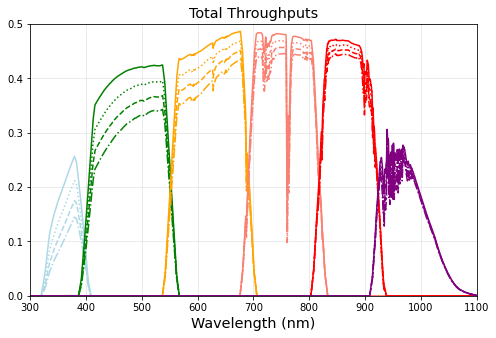

In [12]:
fi = 'leakyfilters'
colors = {'u': 'lightblue', 'g': 'green', 'r': 'orange', 'i': 'salmon', 'z': 'red', 'y': 'purple'}
linestyles = {1.0: '-', 1.5: ':', 2.0: '--', 2.5: '-.'}

plt.figure(figsize=(8,5))
for f in filter_list:
    for x in [1.0, 1.5, 2.0, 2.5]:
        plt.plot(total['detector'][fi][f][x].wavelen, 
                 total['detector'][fi][f][x].sb, 
                 label=f'{f} X={x}', color=colors[f], linestyle=linestyles[x])
plt.grid(True, alpha=0.3)
plt.xlim(300, 1100)
plt.ylim(0, 0.5)
#plt.legend()
plt.xlabel('Wavelength (nm)', fontsize='x-large')
plt.title('Total Throughputs', fontsize='x-large')

Now pull in some stellar and white dwarf SEDS to calculate expected magnitudes and shifts in those magnitudes due to varying color-terms resulting from the varying shape of the SEDS with airmass and comparing 'leaky' vs. 'non-leaky'.

I'm using a subset of SEDS from the imsim catalog, which are archived in a git repo here: https://github.com/rhiannonlynne/photometry_sample

In [13]:
sedDir = '/Users/lynnej/otherRepos/photometry_sample'
stars = {}
for f in os.listdir(os.path.join(sedDir, 'stars')):
    n = f.replace('.dat', '')
    stars[n] = pt.Sed()
    stars[n].readSED_flambda(os.path.join(sedDir, 'stars', f))
white_dwarfs = {}
for f in os.listdir(os.path.join(sedDir, 'white_dwarf')):
    n = f.replace('.dat', '')
    white_dwarfs[n] = pt.Sed()
    white_dwarfs[n].readSED_flambda(os.path.join(sedDir, 'white_dwarf', f))

Text(0.5, 1.0, 'SED')

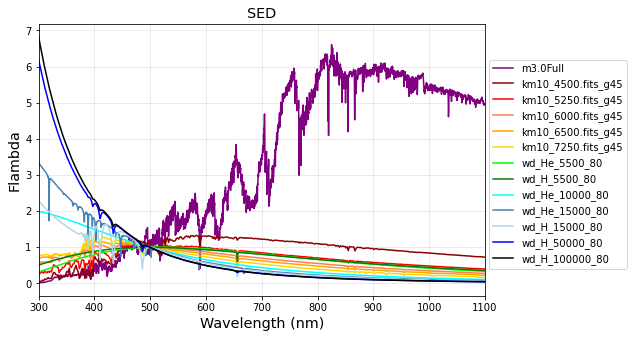

In [14]:
colors = { 'm3.0Full': 'purple', 'km10_4500.fits_g45': 'darkred', 'km10_5250.fits_g45': 'red',
          'km10_6000.fits_g45': 'coral', 'km10_6500.fits_g45': 'orange', 'km10_7250.fits_g45': 'gold',
          'wd_He_5500_80': 'lime', 'wd_H_5500_80': 'green',  'wd_He_10000_80': 'cyan',
          'wd_He_15000_80': 'steelblue', 'wd_H_15000_80': 'lightblue', 'wd_H_50000_80': 'blue',
          'wd_H_100000_80': 'black'}
plt.figure(figsize=(8,5))
for n in colors:
    if n in stars:
        plt.plot(stars[n].wavelen, stars[n].flambda, label=n, linestyle='-', color=colors[n])
    elif n in white_dwarfs:
        plt.plot(white_dwarfs[n].wavelen, white_dwarfs[n].flambda, linestyle='-', color=colors[n], label=n)
    else:
        print(f'missing {n}')
plt.grid(True, alpha=0.3)
plt.xlim(300, 1100)
plt.legend(loc=(1.01, 0.1))
plt.xlabel('Wavelength (nm)', fontsize='x-large')
plt.ylabel('Flambda', fontsize='x-large')
plt.title('SED', fontsize='x-large')

Now let's just go ahead and calculate all of those magnitudes for each airmass and version of the filters, for each sed.

In [15]:
# Calculate natural magnitudes
mags = {}
for n in stars:
    mags[n] = {}
    for d in detectors:
        mags[n][d] = {}
        for fi in ['filters', 'leakyfilters']:
            mags[n][d][fi] = {}
            for f in filter_list:
                mags[n][d][fi][f] = np.zeros(len(airmasses), float)
                for i, x in enumerate(airmasses):
                    mags[n][d][fi][f][i] = stars[n].calcMag(total[d][fi][f][x])
for n in white_dwarfs:
    mags[n] = {}
    for d in detectors:
        mags[n][d] = {}
        for fi in ['filters', 'leakyfilters']:
            mags[n][d][fi] = {}
            for f in filter_list:
                mags[n][d][fi][f] = np.zeros(len(airmasses), float)
                for i, x in enumerate(airmasses):
                    mags[n][d][fi][f][i] = white_dwarfs[n].calcMag(total[d][fi][f][x])               

In [16]:
# Subtract the X=1 magnitude for each combination and turn them into milli-mags (*1000)
for n in mags:
    for d in detectors:
        for fi in ['filters', 'leakyfilters']:
            for f in filter_list:
                mags[n][d][fi][f] = (mags[n][d][fi][f] - mags[n][d][fi][f][0]) * 1000

In [17]:
linestyles = {'filters': '-', 'leakyfilters': ':'}
filtercolors = {'u': 'lightblue', 'g': 'green', 'r': 'orange', 'i': 'salmon', 'z': 'red', 'y': 'purple'}
colors = { 'm3.0Full': 'purple', 'km10_4500.fits_g45': 'darkred', 'km10_5250.fits_g45': 'red',
          'km10_6000.fits_g45': 'coral', 'km10_6500.fits_g45': 'orange', 'km10_7250.fits_g45': 'gold',
          'wd_He_5500_80': 'lime', 'wd_H_5500_80': 'green',  'wd_He_10000_80': 'cyan',
          'wd_He_15000_80': 'steelblue', 'wd_H_15000_80': 'lightblue', 'wd_H_50000_80': 'blue',
          'wd_H_100000_80': 'black'}

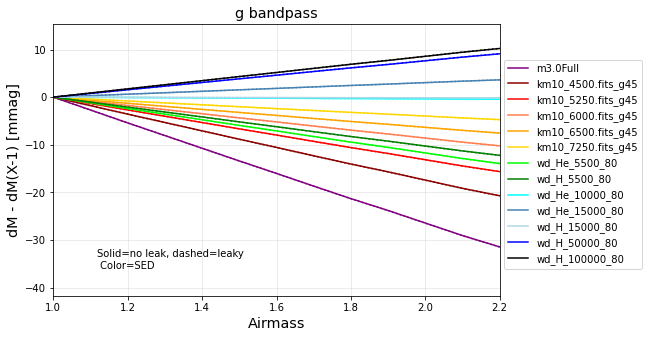

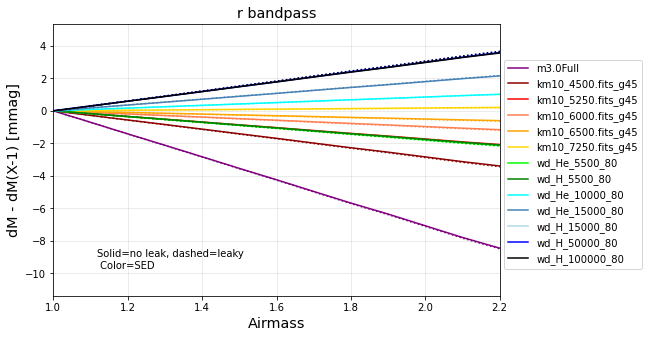

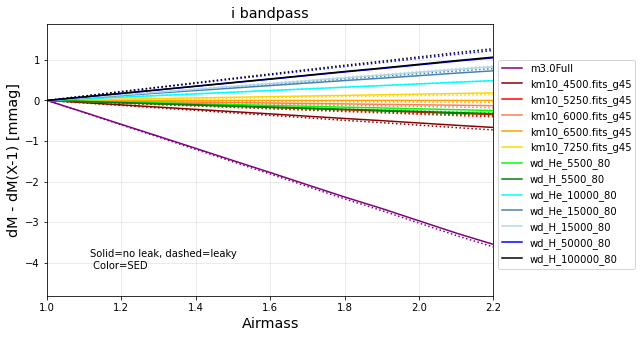

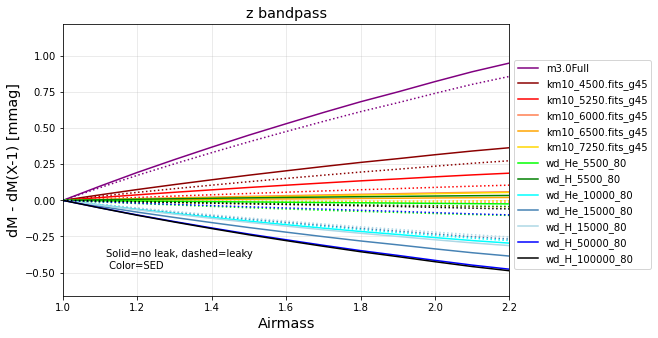

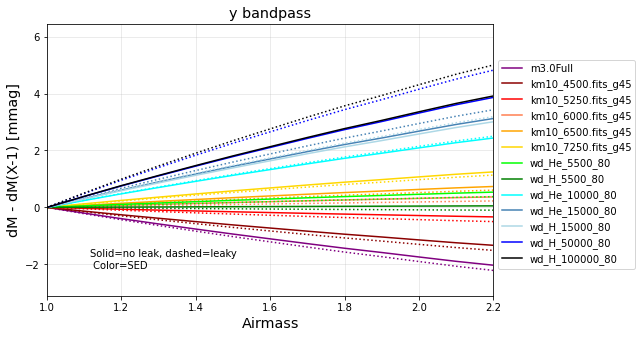

In [18]:
# Plot the change in the natural magnitudes with airmass, for *non-leaky* and *leaky* filters (separately)
for f in ['g', 'r', 'i', 'z', 'y']:
    plt.figure(figsize=(8, 5))
    for n in colors:
        for d in ['detector']:
            plt.plot(airmasses, mags[n][d]['filters'][f], 
                     linestyle=linestyles['filters'], color=colors[n], label=f'{n}')
            plt.plot(airmasses, mags[n][d]['leakyfilters'][f], 
                     linestyle=linestyles['leakyfilters'], color=colors[n])
    plt.legend(loc=(1.01, 0.1))
    plt.xlabel('Airmass', fontsize='x-large')
    plt.ylabel('dM - dM(X-1) [mmag]', fontsize='x-large')
    plt.title(f'{f} bandpass', fontsize='x-large')
    plt.xlim(1.0, 2.2)
    plt.grid(True, alpha=0.3)
    plt.figtext(0.2, 0.2, 'Solid=no leak, dashed=leaky\n Color=SED')

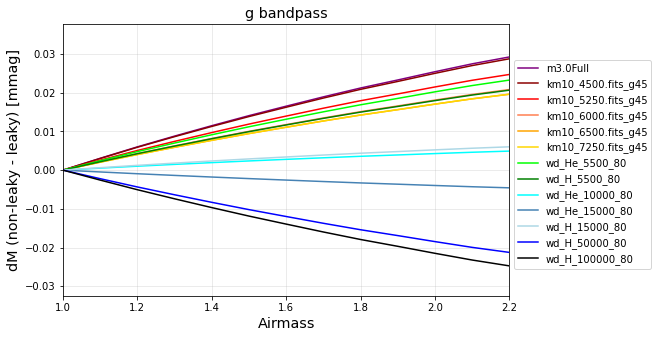

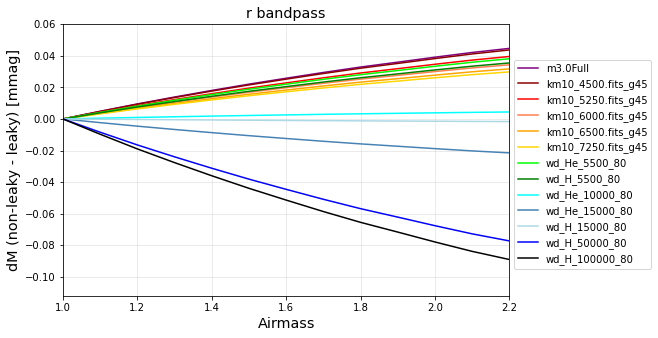

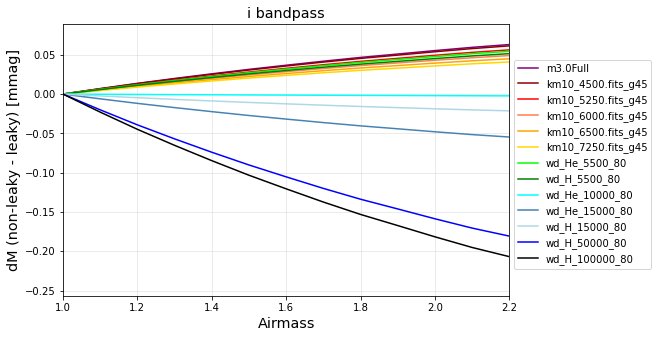

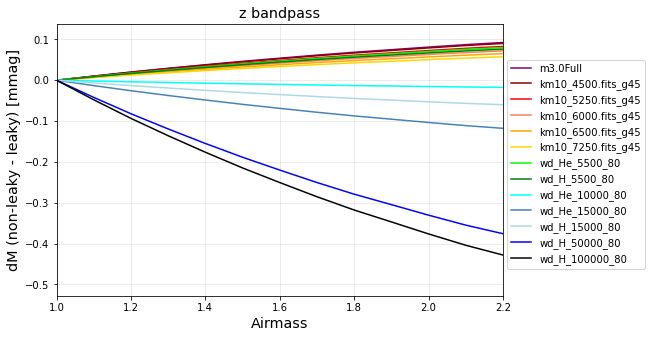

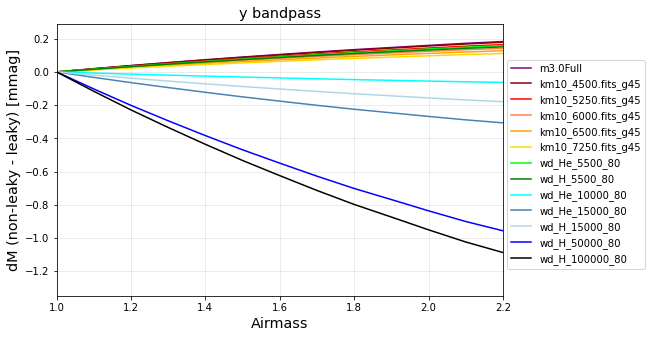

In [19]:
# As that was hard to see, 
# now also plot the difference in the natural magnitudes (compared to X=1) between leaky and non-leaky filters
for f in ['g', 'r', 'i', 'z', 'y']:
    plt.figure(figsize=(8, 5))
    for n in colors:
        for d in ['detector']:
            plt.plot(airmasses, mags[n][d]['filters'][f] - mags[n][d]['leakyfilters'][f],
                     color=colors[n], label=f'{n}')
    plt.legend(loc=(1.01, 0.1))
    plt.xlabel('Airmass', fontsize='x-large')
    plt.ylabel('dM (non-leaky - leaky) [mmag]', fontsize='x-large')
    plt.title(f'{f} bandpass', fontsize='x-large')
    plt.xlim(1.0, 2.2)
    plt.grid(True, alpha=0.3)

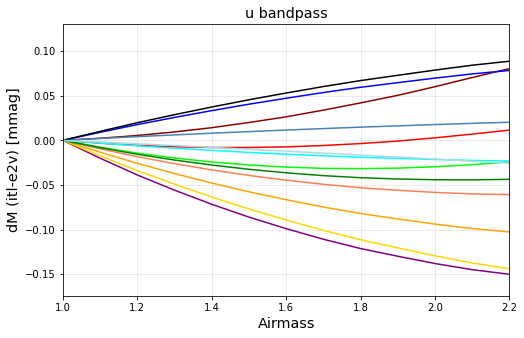

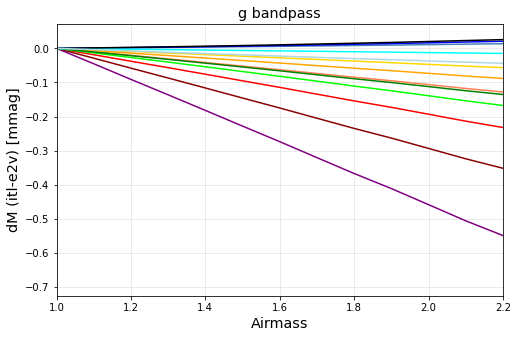

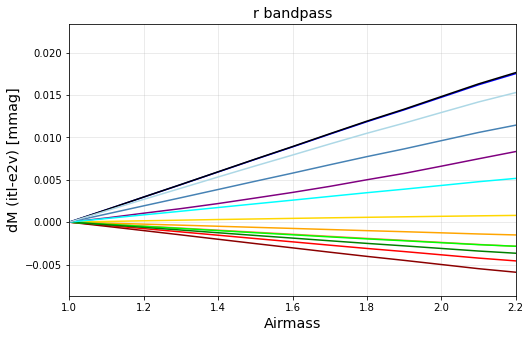

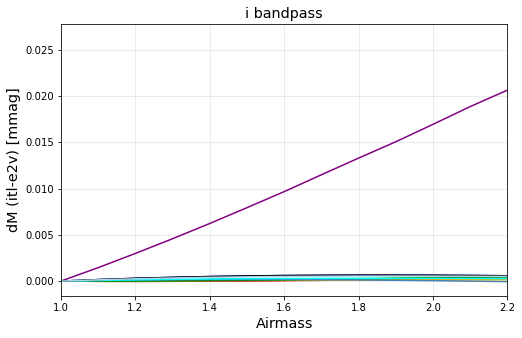

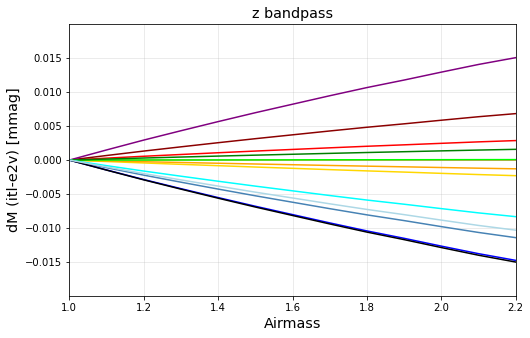

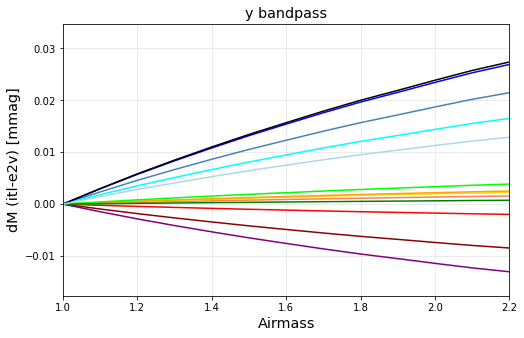

In [20]:
# This is super small. 
# I wondered about the differences between E2V and ITL - except in u/g these differences are smaller though.
for f in ['u', 'g', 'r', 'i', 'z', 'y']:
    plt.figure(figsize=(8, 5))
    for n in mags:
        plt.plot(airmasses, mags[n]['itl']['filters'][f] - mags[n]['e2v']['filters'][f],
                 color=colors[n])
    plt.xlabel('Airmass', fontsize='x-large')
    plt.ylabel('dM (itl-e2v) [mmag]', fontsize='x-large')
    plt.title(f'{f} bandpass', fontsize='x-large')
    plt.xlim(1.0, 2.2)
    plt.grid(True, alpha=0.3)